# Computer Vision - Cat/Dog Recognition

In [3]:
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
import pandas as pd

# Masquer les messages de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Masquer les messages de certaines bibliothèques
logging.getLogger('tensorflow').setLevel(logging.ERROR)


# add category
target = []

all_list = os.listdir('/Users/nathan/Desktop/Étude_Perso/Vision/train')
for p in all_list:
    category = p.split('.')[0]
    if category == 'dog':
        target.append(1)
    else:
        target.append(0)
        
# to dataframe
data = pd.DataFrame({'filenames' : all_list, 'category' : target})
data.head()

,filenames,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [4]:
# reshape with 1500 only 
data_dog = data[data.category == 1].sample(n = 1500, random_state = 42)
data_cat = data[data.category == 0].sample(n = 1500, random_state = 42)
data_final = pd.concat([data_dog, data_cat], axis = 0)
data_final = data_final.sample(frac = 1).reset_index(drop = True)
data_final.head()

,filenames,category
0,cat.2865.jpg,0
1,dog.3244.jpg,1
2,cat.6207.jpg,0
3,cat.7392.jpg,0
4,cat.1085.jpg,0


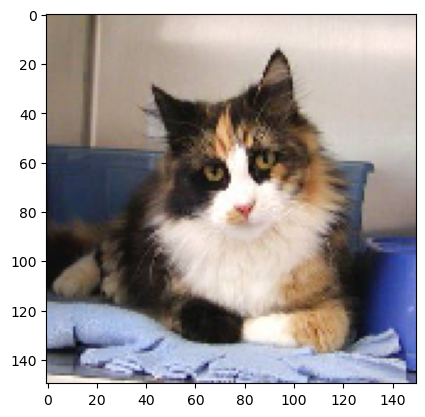

In [6]:
import random
from tensorflow.keras.preprocessing import image

# create random path
PATH = '/Users/nathan/Desktop/Étude_Perso/Vision/train'

All_PATH = PATH + '/' + random.choices(all_list)[0]

IMAGE = image.load_img(path = All_PATH, target_size = (150, 150))
plt.imshow(IMAGE);

# 1. Preprocessing

## Data generator 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data = ImageDataGenerator(rescale = 1./ 255,        # between 0 & 255
                                validation_split = 0.2)   # 20% data for validation

# category values need to be str
data_final.category = data_final.category.astype(str)

### Data generator for training data

In [8]:
train_generator = train_data.flow_from_dataframe(dataframe = data_final, 
                               directory = PATH, 
                               x_col = 'filenames',
                               y_col = 'category',
                               target_size = (150, 150),   # taille uniforme & de petite taille
                               batch_size = 32,
                               class_mode = 'binary',      # classification
                               subset = 'training')        # utilisation de ce dataset pour le training
train_generator

Found 2400 validated image filenames belonging to 2 classes.


### Data generator for validation data

In [9]:
validation_generator = train_data.flow_from_dataframe(dataframe = data_final, 
                               directory = PATH, 
                               x_col = 'filenames',
                               y_col = 'category',
                               target_size = (150, 150),   
                               batch_size = 32,
                               class_mode = 'binary',      
                               subset = 'validation')        # utilisation de ce dataset pour la validation
validation_generator

Found 600 validated image filenames belonging to 2 classes.


(32, 150, 150, 3)
(32,)


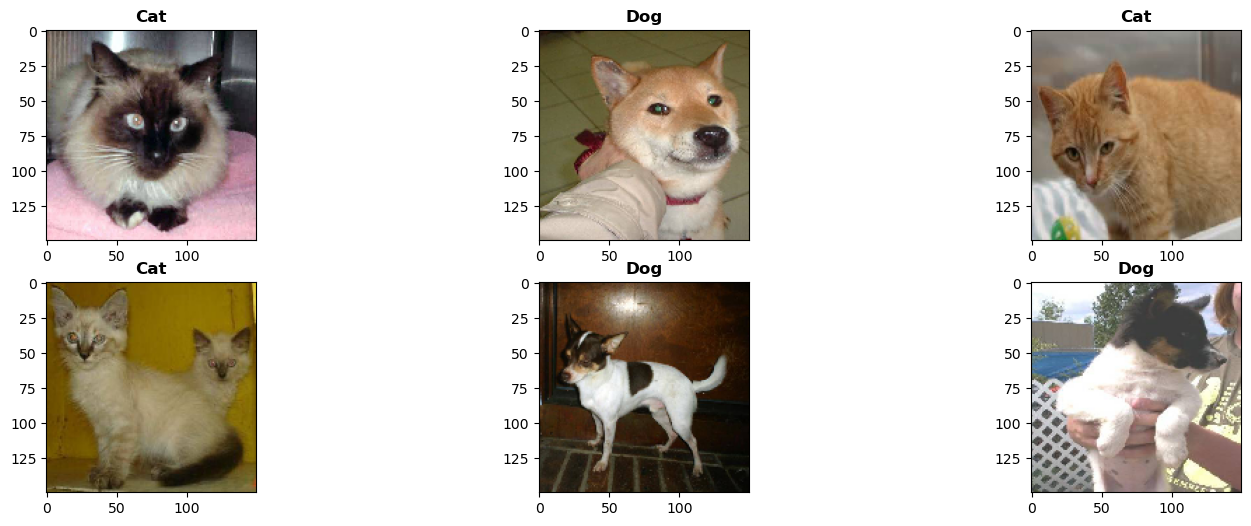

In [12]:
plt.figure(figsize = (18, 6))
for data_batch, label_batch in train_generator:      # data_bach -> 32 images, label_batch -> targets
    print(data_batch.shape)
    print(label_batch.shape)
    
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(data_batch[i])
        plt.title('Cat' if label_batch[i] == 0 else 'Dog', fontweight = 'bold')
    break      # affiche un seul lot d'image

# 2. Building Model


### convolution2D layer

* `filters`: This parameter specifies the number of filters (or kernels) used in this convolution layer. **Each filter will learn a different feature of the image**. In this case, 32 filters will be used (good balance between learning capacity and model complexity).
* `kernel_size`: This parameter defines the size of each filter. Here, each filter will have a size of 3x3 pixels (commonly used).
* `input_shape`: This parameter defines the shape of the input data for this layer. Here, 3 color channels (e.g. an RGB color image). This parameter is only needed for the first layer of a sequential model, so that the model knows the shape of the input data.

### MaxPooling2D layer - Important to place after **each** convolution layer
The MaxPooling2D layer reduces the dimensionality of feature maps by applying maximum subsampling (pooling).

### CNN - Convolutional Neural Network

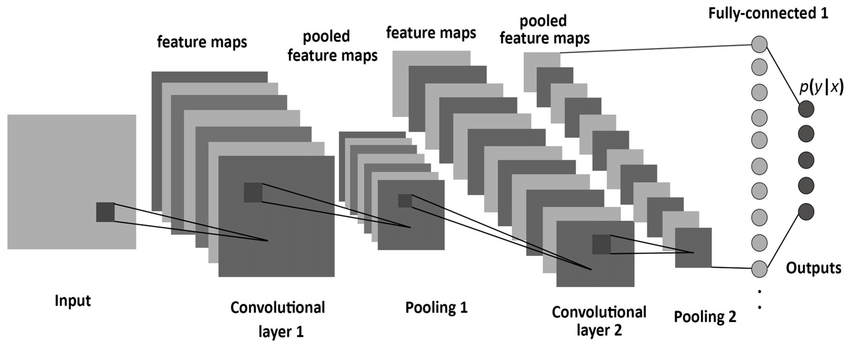

In [17]:
from tensorflow.keras import layers, models

model = models.Sequential()

# add layers one by one
model.add(layers.Conv2D(filters = 32, 
                        kernel_size = (3, 3), 
                        activation = 'relu', 
                        input_shape = (150, 150, 3)))


model.add(layers.MaxPooling2D((2, 2)))
 
model.add(layers.Conv2D(filters = 64,            # detection de motifs plus complexes.
                        kernel_size = (3, 3),
                        activation = 'relu'))

model.add(layers.MaxPooling2D((2, 2)))           # nouvelle réduction des dimensions de l'image

model.add(layers.Conv2D(filters = 128,
                        kernel_size = (3, 3), 
                        activation = 'relu'))    # detection de motifs encore plus complexes. 

model.add(layers.MaxPooling2D((2, 2)))
 
    
model.add(layers.Flatten())                      # transforme les données 2D en vecteur 1D pour la couche Dense suivante
model.add(layers.Dense(units = 128, activation = 'relu'))    # ajout d'une couche Dense pour connecter tous les neurones entre eux
model.add(layers.Dense(units = 64, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))   # probabilitées
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,673 (18.45 MB)

 Trainable params: 4,836,673 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras import optimizers

opti = optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = opti, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [19]:
BATCH_SIZE = train_generator.batch_size
VBATCH_SIZE = validation_generator.batch_size

history = model.fit(x = train_generator, 
                    #steps_per_epoch = train_generator.samples // BATCH_SIZE,     # batches a éxécuter a chaque epoch
                    epochs = 30,                                                 # total epoch
                    validation_data = validation_generator, 
                    #validation_steps = validation_generator.samples // VBATCH_SIZE, 
                    verbose = 1)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4861 - loss: 0.7056 - val_accuracy: 0.4783 - val_loss: 0.6959
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5573 - loss: 0.6900 - val_accuracy: 0.5967 - val_loss: 0.6650
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6052 - loss: 0.6706 - val_accuracy: 0.6083 - val_loss: 0.6750
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6660 - loss: 0.6054 - val_accuracy: 0.6833 - val_loss: 0.5893
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.6977 - loss: 0.5658 - val_accuracy: 0.5983 - val_loss: 0.6775
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7437 - loss: 0.5334 - val_accuracy: 0.7017 - val_loss: 0.5816
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7649 - loss: 0.4881 - val_accuracy: 0.7083 - val_loss: 0.5775
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8121 - loss: 0.4103 - val_accuracy: 0.7433 - val_loss

### Evaluation of model performance based on validation`

In [20]:
validation_steps = validation_generator.samples // VBATCH_SIZE
evaluation = model.evaluate(x = validation_generator, batch_size = validation_steps)

print(f'Loss on Validation: {evaluation[0]}')
print(f'Accuracy on Validation: {evaluation[1]}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.7332 - loss: 1.9702
Loss on Validation: 1.9261232614517212
Accuracy on Validation: 0.7283333539962769


In [21]:
# accuracy
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# losses
loss = history.history['loss']
val_loss = history.history['val_loss']

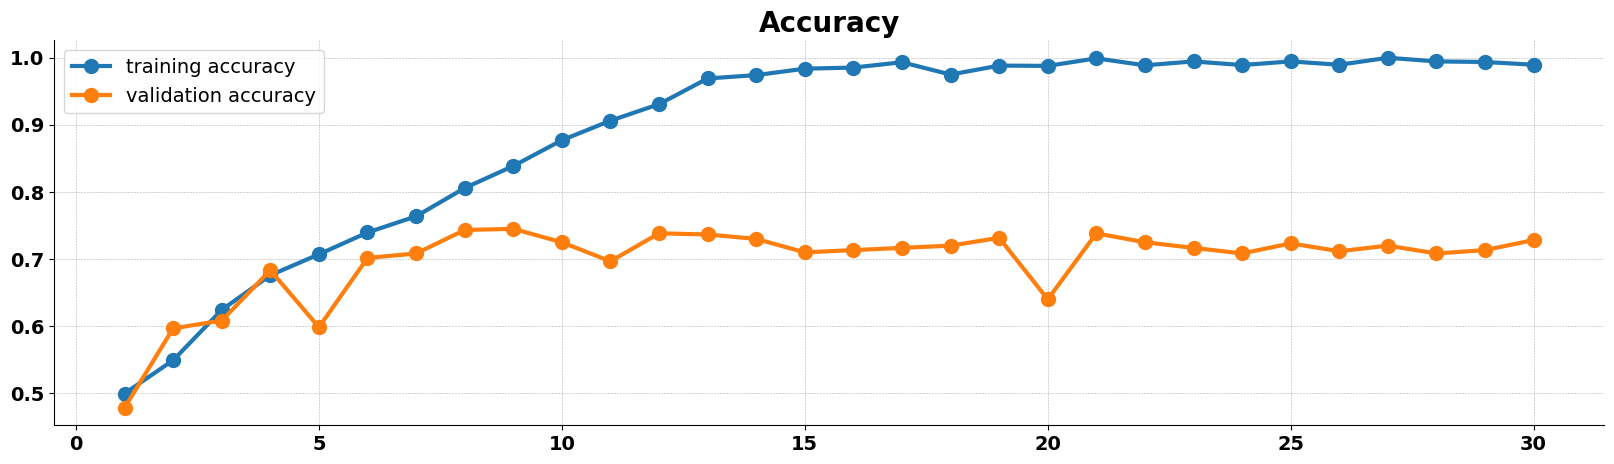

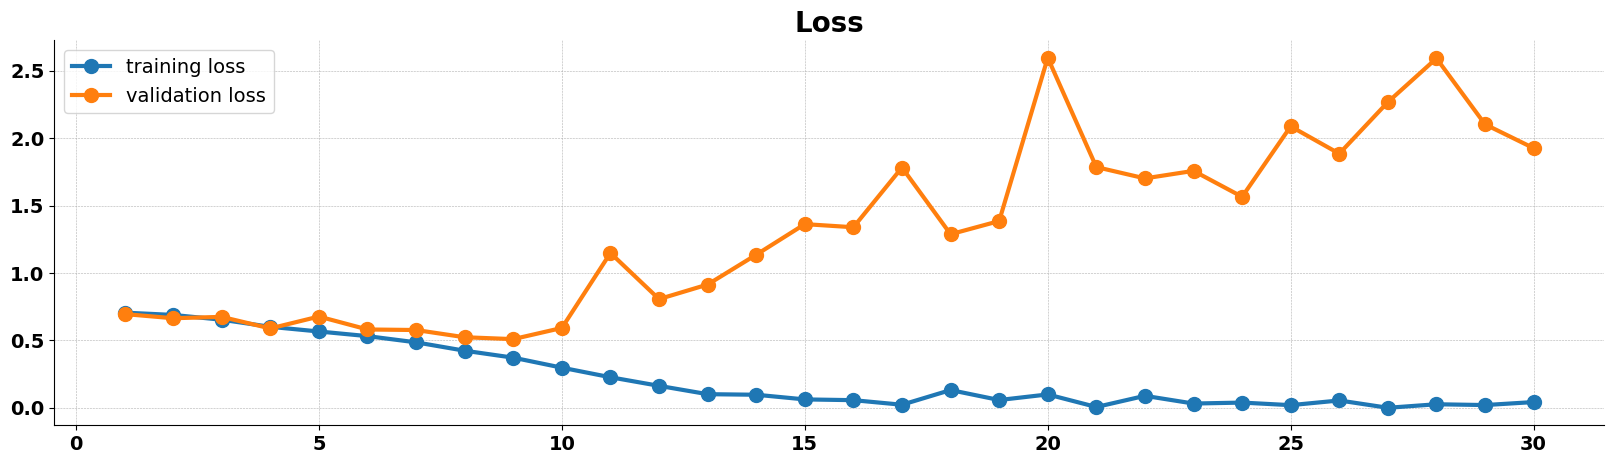

In [22]:
epoch_num = range(1, len(acc) + 1)


plt.figure(figsize = (20, 5))
plt.plot(epoch_num, acc, label = 'training accuracy', lw = 3, marker = 'o', markersize = 10)
plt.plot(epoch_num, val_accuracy, label = 'validation accuracy', lw = 3, marker = 'o', markersize = 10)
plt.title('Accuracy', fontweight = 'bold', fontsize = 20)
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 14)
plt.grid(True, lw = 0.4, ls = '--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(epoch_num, loss, label = 'training loss', lw = 3, marker = 'o', markersize = 10)
plt.plot(epoch_num, val_loss, label = 'validation loss', lw = 3, marker = 'o', markersize = 10)
plt.title('Loss', fontweight = 'bold', fontsize = 20)
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 14)
plt.grid(True, lw = 0.4, ls = '--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Save Model

In [24]:
from keras.models import load_model

save_path = '/Users/nathan/Desktop/Étude_Perso/Vision/vision_model.h5'
model.save(save_path)

print(f'Model Saved: {save_path}')

Model Saved: /Users/nathan/Desktop/Étude_Perso/Vision/vision_model.h5


### Import Model for Predictions on Test

In [26]:
from keras.utils import load_img, img_to_array

model = load_model('/Users/nathan/Desktop/Étude_Perso/Vision/vision_model.h5')
print('Model Loaded.')

Model Loaded.


In [27]:
# select randomly 10 images of cat & dog

cat_test = data[data.category == 0].sample(n = 10, random_state = 42)
dog_test = data[data.category == 1].sample(n = 10, random_state = 42)

final_test = pd.concat([cat_test, dog_test]).reset_index(drop = True)
final_test.category = final_test.category.astype(str)

final_test.head()

,filenames,category
0,cat.2332.jpg,0
1,cat.5319.jpg,0
2,cat.5622.jpg,0
3,cat.12119.jpg,0
4,cat.11535.jpg,0


In [29]:
test_datagen = ImageDataGenerator(rescale = 1./ 255)
test_generator = test_datagen.flow_from_dataframe(dataframe = data_final, 
                               directory = PATH, 
                               x_col = 'filenames',
                               y_col = 'category',
                               target_size = (150, 150),   
                               batch_size = 10,
                               class_mode = 'binary',      
                               shuffle = False)            # not need to shuffle in test data

predictions = model.predict(test_generator)
predictions

Found 3000 validated image filenames belonging to 2 classes.
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step


array([[9.0603405e-01],
       [9.9999988e-01],
       [2.9360109e-10],
       ...,
       [2.8297446e-14],
       [9.9976087e-01],
       [3.0970295e-05]], dtype=float32)

### Convert predictions into classes

In [30]:
integer_prediction = (predictions > 0.5).astype(int).flatten()
name_prediction = ['dog' if element > 0.5 else 'cat' for element in predictions]

print(integer_prediction[:10])
print(name_prediction[:10])

[1 1 0 0 0 0 0 1 1 1]
['dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog']


In [31]:
final_test['Real'] = final_test.filenames.apply(lambda x: x.split('.')[0])
final_test['Predict'] = pd.Series(name_prediction)
final_test.head()

,filenames,category,Real,Predict
0,cat.2332.jpg,0,cat,dog
1,cat.5319.jpg,0,cat,dog
2,cat.5622.jpg,0,cat,cat
3,cat.12119.jpg,0,cat,cat
4,cat.11535.jpg,0,cat,cat


In [33]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true = final_test.Real, y_pred = final_test.Predict)
print(f'The accuracy of the model is: {accuracy}%')

The accuracy of the model is: 0.5%


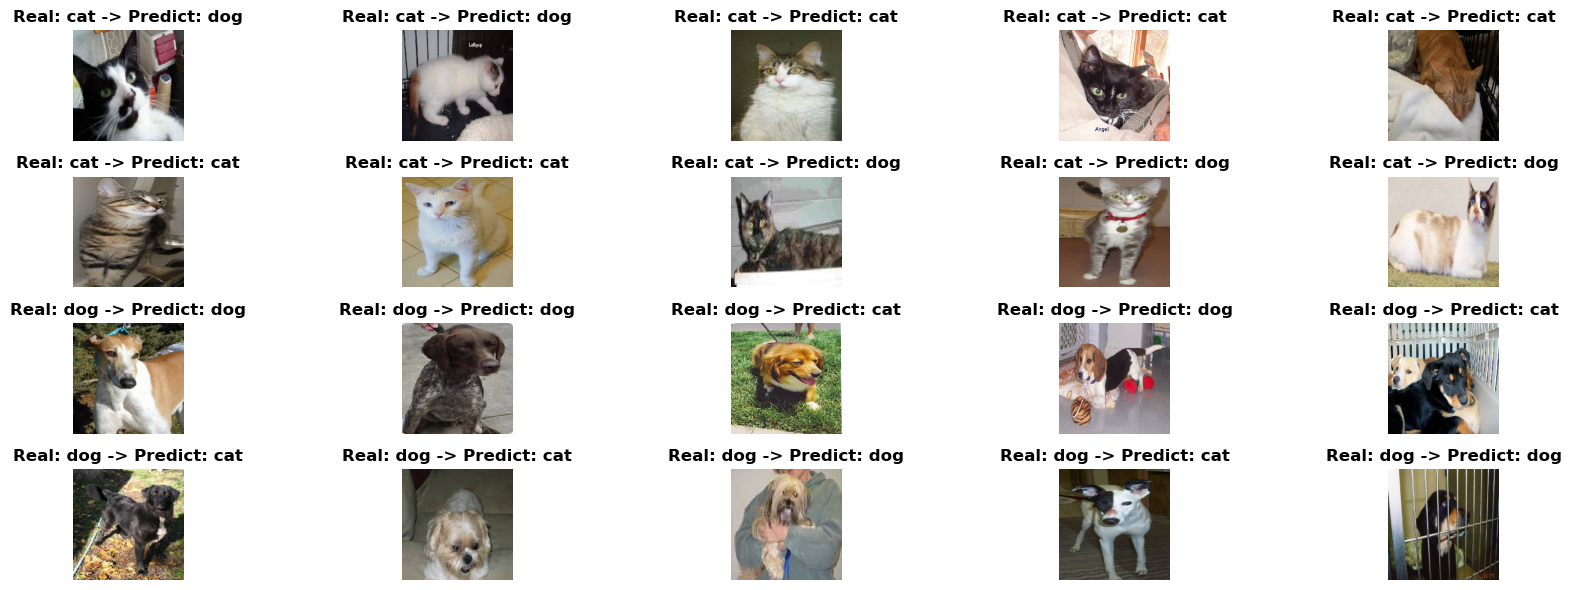

In [34]:
plt.figure(figsize = (18, 6))
for _ , row in final_test.iterrows():
    plt.subplot(4, 5, _ + 1)
    img_path = f"/Users/nathan/Desktop/Étude_Perso/Vision/train/{row['filenames']}"
    img = load_img(img_path, target_size = (200, 200))
    plt.imshow(img)
    plt.title(f"Real: {row.Real} -> Predict: {row.Predict}", fontweight = 'bold', fontsize = 12)
    plt.axis('off')
    
plt.tight_layout()
plt.show()